In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from util import compute_batch_accuracy

# Convolutional Neural Networks
## LeNet-5

![LeNet-5](img/LeNet5-architecture.png)
*Source: Original paper available at: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf*

In [11]:
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes, greyscale):
        super(LeNet5, self).__init__()
        self.greyscale = greyscale
        if greyscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        features = torch.flatten(features, 1)
        logits = self.classifier(features)
        probas = torch.softmax(logits, dim=1)
        return logits, probas

## LeNet5 on MNIST

In [23]:
# Architecture
num_classes = 10

# Hyperparameters
learning_rate = 0.1
batch_size = 256
num_epochs = 2
random_seed = 0

# Data loaders
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train = torchvision.datasets.MNIST(
    root='data',
    transform=data_transform, 
    download=True
)

train, valid = torch.utils.data.random_split(train, [50000, 10000])

test = torchvision.datasets.MNIST(
    root='data', 
    transform=data_transform, 
    train=False
)

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True
)

valid_loader = DataLoader(
    valid,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test,
    batch_size=batch_size,
    shuffle=False
)

In [24]:
import time
torch.manual_seed(random_seed)
model = LeNet5(num_classes, greyscale=True)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.1, 
    mode='max', 
    verbose=True
)
loss_fn = torch.nn.CrossEntropyLoss()

train_acc_ls, valid_acc_ls, mini_batch_loss_ls = [], [], []

start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, target) in enumerate(train_loader):

        # FORWARD
        logits, probs = model(features)

        # BACKWARD
        loss = loss_fn(logits, target)
        mini_batch_loss_ls.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        
        # UPDATE WEIGHTS
        optimizer.step()
        
        # BATCH LOGGING
        if batch_idx % 50 == 0:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch + 1, num_epochs, batch_idx, batch_size, loss))

    # EPOCH LOGGING
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

    train_acc = compute_batch_accuracy(model, train_loader)
    valid_acc = compute_batch_accuracy(model, valid_loader)
    print('Epoch: %03d/%03d Train: %.2f%% | Validation: %.2f%%' % (
        epoch + 1, num_epochs, train_acc, valid_acc
    ))
    train_acc_ls.append(train_acc)
    valid_acc_ls.append(valid_acc)

    # ADJUST LEARNING RATE
    scheduler.step(valid_acc_ls[-1])

print("-------------------------------")

# FINAL LOGGING
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

test_acc = compute_batch_accuracy(model, test_loader)
print(f'Test accuracy {test_acc :.2f}%')

Epoch: 001/002 | Batch 000/256 | Cost: 2.3083
Epoch: 001/002 | Batch 050/256 | Cost: 1.1761
Epoch: 001/002 | Batch 100/256 | Cost: 0.5426
Epoch: 001/002 | Batch 150/256 | Cost: 0.3229
Time elapsed: 0.27 min
Epoch: 001/002 Train: 92.45% | Validation: 91.85%
Epoch: 002/002 | Batch 000/256 | Cost: 0.2498
Epoch: 002/002 | Batch 050/256 | Cost: 0.1783
Epoch: 002/002 | Batch 100/256 | Cost: 0.2096
Epoch: 002/002 | Batch 150/256 | Cost: 0.2210
Time elapsed: 0.71 min
Epoch: 002/002 Train: 95.59% | Validation: 95.02%
-------------------------------
Total Training Time: 0.90 min
Test accuracy 95.79%


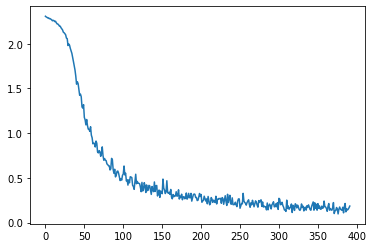

In [25]:
plt.plot(mini_batch_loss_ls)

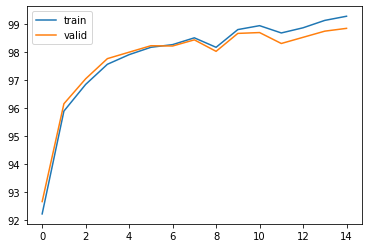

In [18]:
plt.plot(train_acc_ls, label="train")
plt.plot(valid_acc_ls, label="valid")
plt.legend()
plt.show()